# Predicting Car prices using simple K Nearest Neighbor model

In [1]:
import pandas as pd
import numpy as np

In [2]:
columns=['symboling', 'normalized-losses', 'make', 'fuel-type', 'aspiration', 'num-of-doors', 'body-style', 
        'drive-wheels', 'engine-location', 'wheel-base', 'length', 'width', 'height', 'curb-weight', 'engine-type', 
        'num-of-cylinders', 'engine-size', 'fuel-system', 'bore', 'stroke', 'compression-rate', 'horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg', 'price']

In [3]:
cars=pd.read_csv('imports-85.data',names=columns)

## Cleaning data and pre-processing
Finding the integer colums that we would be able to work with for our predictions

In [4]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
symboling            205 non-null int64
normalized-losses    205 non-null object
make                 205 non-null object
fuel-type            205 non-null object
aspiration           205 non-null object
num-of-doors         205 non-null object
body-style           205 non-null object
drive-wheels         205 non-null object
engine-location      205 non-null object
wheel-base           205 non-null float64
length               205 non-null float64
width                205 non-null float64
height               205 non-null float64
curb-weight          205 non-null int64
engine-type          205 non-null object
num-of-cylinders     205 non-null object
engine-size          205 non-null int64
fuel-system          205 non-null object
bore                 205 non-null object
stroke               205 non-null object
compression-rate     205 non-null float64
horsepower           205 non-nul

In [5]:
cars.head()

,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,...,engine-size,fuel-system,bore,stroke,compression-rate,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495
1,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500
2,1,?,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500
3,2,164,audi,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950
4,2,164,audi,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450


Defining a separate DF to only keep numeric columns, replace the ? with nan and convert all the data to numbers

In [6]:
numeric_columns= ['normalized-losses', 'wheel-base', 'length', 'width', 'height', 'curb-weight', 'bore', 'stroke', 'compression-rate', 'horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg', 'price']
numeric_cars=cars[numeric_columns]
numeric_cars.head()

,normalized-losses,wheel-base,length,width,height,curb-weight,bore,stroke,compression-rate,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,?,88.6,168.8,64.1,48.8,2548,3.47,2.68,9.0,111,5000,21,27,13495
1,?,88.6,168.8,64.1,48.8,2548,3.47,2.68,9.0,111,5000,21,27,16500
2,?,94.5,171.2,65.5,52.4,2823,2.68,3.47,9.0,154,5000,19,26,16500
3,164,99.8,176.6,66.2,54.3,2337,3.19,3.40,10.0,102,5500,24,30,13950
4,164,99.4,176.6,66.4,54.3,2824,3.19,3.40,8.0,115,5500,18,22,17450


In [7]:
numeric_cars=numeric_cars.replace('?',np.nan)

In [8]:
numeric_cars=numeric_cars.astype('float')

In [9]:
numeric_cars.isnull().sum().sort_values()

wheel-base            0
length                0
width                 0
height                0
curb-weight           0
compression-rate      0
city-mpg              0
highway-mpg           0
horsepower            2
peak-rpm              2
bore                  4
stroke                4
price                 4
normalized-losses    41
dtype: int64

For the price column, we need it for prediction so since there are few missings we just drop null rows. For the rest of the columns we fill null values with the mean of corresponding column.

In [10]:
numeric_cars.dropna(subset=['price'],inplace=True)

In [11]:
numeric_cars.isnull().sum()

normalized-losses    37
wheel-base            0
length                0
width                 0
height                0
curb-weight           0
bore                  4
stroke                4
compression-rate      0
horsepower            2
peak-rpm              2
city-mpg              0
highway-mpg           0
price                 0
dtype: int64

In [12]:
numeric_cars.fillna(numeric_cars.mean(),inplace=True)

In [13]:
numeric_cars.isnull().sum()

normalized-losses    0
wheel-base           0
length               0
width                0
height               0
curb-weight          0
bore                 0
stroke               0
compression-rate     0
horsepower           0
peak-rpm             0
city-mpg             0
highway-mpg          0
price                0
dtype: int64

Normalizing all the values to range between 0 and 1 except the target price column

In [25]:
sep_price=numeric_cars['price']
numeric_cars=(numeric_cars-numeric_cars.min())/(numeric_cars.max()-numeric_cars.min())

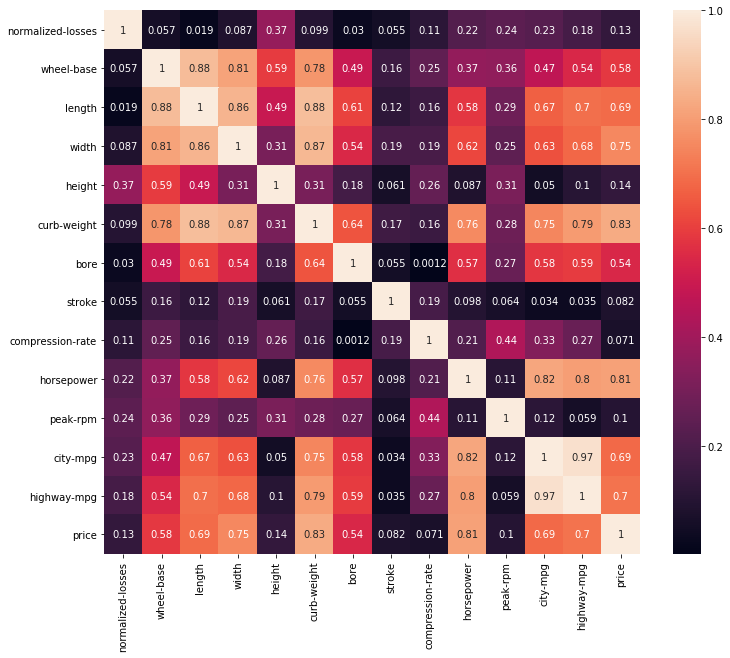

In [29]:
import seaborn as sns
plt.figure(figsize=[12,10])
sns.heatmap(numeric_cars.corr().abs(), annot=True);

## Starting the KNN Univariate model for prediction

In [15]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

def knn_train_test(training_column,target_column,DF):
    kvalues=[1,3,5,7,9]
    np.random.seed(1)
    shuffled=np.random.permutation(DF.index)
    randomDF=DF.reindex(shuffled)
    
    #divide the dataset into training and testing sets
    
    last_tr=int(len(DF)/2)
    training=randomDF.iloc[0:last_tr]
    testing=randomDF.iloc[last_tr:]
    
    #train dataset for different number of neighbors for each feature
    krmse={}
    for items in kvalues:
        knn=KNeighborsRegressor(n_neighbors=items)
        knn.fit(training[[training_column]],training[target_column])
    
    # make prediction on the test dataset
    
        predicted_value=knn.predict(testing[[training_column]])
    
    #calculate the RMSE of the prediction
    
        mse=mean_squared_error(testing[target_column],predicted_value)
        krmse[items]=np.sqrt(mse)
    
    return(krmse)

rmsvalues={}
trainingcols=numeric_cars.columns.drop('price')
for cols in trainingcols:
    col_rmse=knn_train_test(cols,'price',numeric_cars)
    rmsvalues[cols]=col_rmse
rmsvalues    

    

{'normalized-losses': {1: 0.19479545715577634,
  3: 0.1862015245596294,
  5: 0.1819720384646851,
  7: 0.19255304071878562,
  9: 0.19085686154836978},
 'wheel-base': {1: 0.11155687574625128,
  3: 0.12710792676789912,
  5: 0.13558298986825523,
  7: 0.13524916963860611,
  9: 0.1424558285386106},
 'length': {1: 0.11490133313180999,
  3: 0.127348091481857,
  5: 0.13473017627815678,
  7: 0.1319057574313086,
  9: 0.13363424146848335},
 'width': {1: 0.11318348885234251,
  3: 0.11435414557792316,
  5: 0.11678870437675352,
  7: 0.11348704250520464,
  9: 0.11550851924104531},
 'height': {1: 0.22104280960132835,
  3: 0.20549152581911342,
  5: 0.20218561746347616,
  7: 0.19064589951824074,
  9: 0.19390884422104737},
 'curb-weight': {1: 0.13068592003274115,
  3: 0.12467896360054696,
  5: 0.109257689657741,
  7: 0.10750727631244858,
  9: 0.11499042933455146},
 'bore': {1: 0.2135591203143007,
  3: 0.17338363262700254,
  5: 0.1683289753409954,
  7: 0.17074867101736585,
  9: 0.1704684102586369},
 'strok

### Visualizing the results of training based on different features and different values for the hyperparameter : neighbors

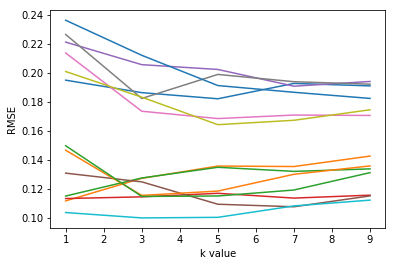

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

for k,v in rmsvalues.items():
    x = list(v.keys())
    y = list(v.values())
    tempdf=pd.DataFrame()
    tempdf['k']=x
    tempdf['error']=y
    tempdf=tempdf.sort_values('k')
    x=tempdf['k']
    y=tempdf['error']
    plt.plot(x,y)
    plt.xlabel('k value')
    plt.ylabel('RMSE')


## KNN Multivariate model

In [17]:
def knn_train_test(training_columns,target_column,DF):
    np.random.seed(1)
    shuffled=np.random.permutation(DF.index)
    randomDF=DF.reindex(shuffled)
    
    #divide the dataset into training and testing sets
    
    last_tr=int(len(DF)/2)
    training=randomDF.iloc[0:last_tr]
    testing=randomDF.iloc[last_tr:]
    
    #train dataset for different number of neighbors for each feature
    knn=KNeighborsRegressor()
    knn.fit(training[training_columns],training[target_column])
    
    # make prediction on the test dataset
    
    predicted_value=knn.predict(testing[training_columns])
    
    #calculate the RMSE of the prediction
    
    mse=mean_squared_error(testing[target_column],predicted_value)
    krmse=np.sqrt(mse)
    
    return(krmse)


Now we sort the RMSE values of different features, predict based on different combinations and compare accuracy of predictions.

### Average rmse for each feature across all Ks

In [18]:
sorted_rmse = {}
for k,v in rmsvalues.items():
    avg = np.mean(list(v.values()))
    sorted_rmse[k] = avg
seriesrmse = pd.Series(sorted_rmse)
seriesrmse.sort_values()

horsepower           0.104746
width                0.114664
curb-weight          0.117424
highway-mpg          0.125849
length               0.128504
city-mpg             0.129150
wheel-base           0.130391
compression-rate     0.177898
bore                 0.179298
normalized-losses    0.189276
stroke               0.198606
peak-rpm             0.201563
height               0.202655
dtype: float64

In [19]:
#predict based on all the features
rmsefeatures={}

allcols=numeric_cars.columns.drop('price')
all_rmse=knn_train_test(allcols,'price',numeric_cars)
rmsefeatures['all']=all_rmse

#predict based on the two most relevent features

twobest=['horsepower','width']
two_rmse=knn_train_test(twobest,'price',numeric_cars)
rmsefeatures['best_two']=two_rmse


#predict based on the three most relevent features

threebest=['horsepower','width','curb-weight']
three_rmse=knn_train_test(threebest,'price',numeric_cars)
rmsefeatures['best_three']=three_rmse


#predict based on the four most relevent features

fourbest=['horsepower','width','curb-weight','length']
four_rmse=knn_train_test(fourbest,'price',numeric_cars)
rmsefeatures['best_four']=four_rmse

#predict based on the five most relevent features

fivebest=['horsepower','width','curb-weight','length','city-mpg']
five_rmse=knn_train_test(fivebest,'price',numeric_cars)
rmsefeatures['best_five']=five_rmse

rmsefeatures_series=pd.Series(rmsefeatures)
rmsefeatures_series=rmsefeatures_series.sort_values()
rmsefeatures_series

best_three    0.082070
best_five     0.087996
best_two      0.089105
best_four     0.090666
all           0.103368
dtype: float64

## Multivariate features as well as the Neighbors

In [20]:
def knn_train_test(training_column,target_column,DF):
    kvalues=[i for i in range(1,25)]
    np.random.seed(1)
    shuffled=np.random.permutation(DF.index)
    randomDF=DF.reindex(shuffled)
    
    #divide the dataset into training and testing sets
    
    last_tr=int(len(DF)/2)
    training=randomDF.iloc[0:last_tr]
    testing=randomDF.iloc[last_tr:]
    
    #train dataset for different number of neighbors for each feature
    krmse={}
    for items in kvalues:
        knn=KNeighborsRegressor(n_neighbors=items)
        knn.fit(training[training_column],training[target_column])
    
    # make prediction on the test dataset
    
        predicted_value=knn.predict(testing[training_column])
    
    #calculate the RMSE of the prediction
    
        mse=mean_squared_error(testing[target_column],predicted_value)
        krmse[items]=np.sqrt(mse)
    
    return(krmse)

In [21]:
multik={}
twobest=['horsepower','width']
two_rmsek=knn_train_test(twobest,'price',numeric_cars)
multik['best_two']=two_rmsek

threebest=['horsepower','width','curb-weight']
three_rmsek=knn_train_test(threebest,'price',numeric_cars)
multik['best_three']=three_rmsek

fivebest=['horsepower','width','curb-weight','length','city-mpg']
five_rmsek=knn_train_test(fivebest,'price',numeric_cars)
multik['best_five']=five_rmsek

multik

{'best_two': {1: 0.10083812385259944,
  2: 0.08682536522494365,
  3: 0.08447617456070232,
  4: 0.08904732684165861,
  5: 0.08910464381627849,
  6: 0.09135750412331806,
  7: 0.09326567608536965,
  8: 0.09775508709259847,
  9: 0.10124493798644581,
  10: 0.10336697219126981,
  11: 0.1066763309404012,
  12: 0.10850387318754108,
  13: 0.11172389724167753,
  14: 0.11429811597454889,
  15: 0.11407936788394846,
  16: 0.11432981654113557,
  17: 0.11447506538497647,
  18: 0.11416717602952114,
  19: 0.11369755453965684,
  20: 0.11553465184728628,
  21: 0.11814398638084585,
  22: 0.11935370511200559,
  23: 0.12078151251501873,
  24: 0.12190843972600138},
 'best_three': {1: 0.07479794941969584,
  2: 0.06983977880507417,
  3: 0.0787345535097233,
  4: 0.07900088728956343,
  5: 0.08206991062501781,
  6: 0.08744617568393764,
  7: 0.09369885332047591,
  8: 0.0987778442982254,
  9: 0.0991242659398461,
  10: 0.10119254623356101,
  11: 0.10318227325186949,
  12: 0.10429241680799066,
  13: 0.106837465086471

### visualizing the results for the combination of various training features and hyperparameter: K

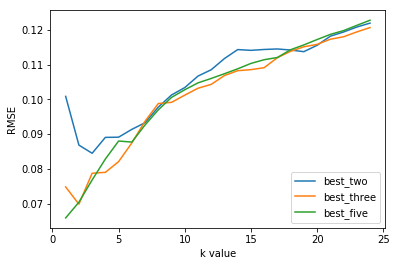

In [22]:
for k,v in multik.items():
    x = list(v.keys())
    y = list(v.values())
    tempdf=pd.DataFrame()
    tempdf['k']=x
    tempdf['error']=y
    tempdf=tempdf.sort_values('k')
    x=tempdf['k']
    y=tempdf['error']
    plt.plot(x,y,label=k)
    plt.xlabel('k value')
    plt.ylabel('RMSE')
    plt.legend(loc='lower right')

The results confirm that as we increase the training features we are increasing the variance while with using two features we are increasing bias. For the two features case the optimum K is around 4 while it is lower for the other two cases. It is better to use the best_three features to predict because of the following reasons:

- For big sets of data we need to reduce the calculations and therefore three is more optimizied than 5.

-  Five is having the variance effect and two has the bias effect.

-  With using around three neighbors we get as good results as five neighbors for this case which is not a big K.
